In [1]:
!pip install sentence-transformers

     |████████████████████████████████| 61kB 3.7MB/s 
     |████████████████████████████████| 645kB 6.4MB/s 
     |████████████████████████████████| 3.8MB 16.6MB/s 
     |████████████████████████████████| 1.1MB 51.0MB/s 
     |████████████████████████████████| 890kB 50.1MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.6.1-cp36-none-any.whl size=74031 sha256=8fd6f35418a495e642f591826a1649d4d620425b18b04cb78c30ea0bcfa642c4
  Stored in directory: /root/.cache/pip/wheels/d7/fa/17/2b081a8cd8b0a86753fb0e9826b3cc19f0207062c0b2da7008
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=be2450c61608e016dc10f7a6df26a74c58e1d9b2e68117d5bb0445f311fabe1d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [2]:
import pandas as pd
import pickle as pkl

output_df = pd.read_csv("/content/drive/My Drive/COVID Press/covid_press_QA.csv")
output_df.head()

,questions,answers,time,transcript_link,date,header,main_page_counter
0,Governor Cuomo. You mentioned that New York or...,It’s always the same. You start reopening that...,33:29,https://www.rev.com/transcript-editor/shared/_...,"May 12, 2020",Andrew Cuomo New York COVID-19 Press Conferenc...,0
1,"When you talk about closing the valve, say we ...","Well, if you’re calibrating the reopening and ...",34:09,https://www.rev.com/transcript-editor/shared/_...,"May 12, 2020",Andrew Cuomo New York COVID-19 Press Conferenc...,0
2,"Governor, one major Southern Tier institution ...",We’ll work with any employer on how to adopt s...,35:28,https://www.rev.com/transcript-editor/shared/_...,"May 12, 2020",Andrew Cuomo New York COVID-19 Press Conferenc...,0
3,"Governor, you talked about staying smart and w...",Yeah. That’s going to be up to the local healt...,36:14,https://www.rev.com/transcript-editor/shared/_...,"May 12, 2020",Andrew Cuomo New York COVID-19 Press Conferenc...,0
4,Thank you. Is New York setting up a system in ...,We live in fear of a second wave. If you see t...,36:59,https://www.rev.com/transcript-editor/shared/_...,"May 12, 2020",Andrew Cuomo New York COVID-19 Press Conferenc...,0


In [0]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import models, losses
import scipy.spatial
import pickle as pkl
word_embedding_model = models.BERT("/content/drive/My Drive/COVID Press/BertCovid")

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [0]:
questions = list(output_df["questions"])
corpus_embeddings = model.encode(questions)

In [0]:
import pickle as pkl
with open("/content/drive/My Drive/COVID Press/corpus_embeddings.pkl" , "wb") as file_:
  pkl.dump(corpus_embeddings,file_)

In [0]:
with open("/content/drive/My Drive/COVID Press/corpus_embeddings.pkl" , "rb") as file_:
  corpus_embeddings = pkl.load(file_)

In [0]:
from sklearn.cluster import KMeans

num_clusters = 10
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

In [0]:
import nltk
#nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

In [0]:
from collections import Counter 
from nltk.corpus import stopwords
from nltk import pos_tag

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(questions[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    data_set = " ".join(cluster)
    split_it = data_set.split() 
    sent = pos_tag(split_it)
    split_it_stops = [s for s in sent if s[1] == 'NN']
    print(len(split_it))
    print(len(split_it_stops))
    counter = Counter(split_it_stops)  
    most_occur = counter.most_common(10) 
    print(most_occur) 
    print("")

In [0]:
len(cluster)

1536

## Clustering

https://www.kaggle.com/maksimeren/covid-19-literature-clustering

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_reduced = tsne.fit_transform(corpus_embeddings)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 7990 samples in 0.235s...
[t-SNE] Computed neighbors for 7990 samples in 41.564s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7990
[t-SNE] Computed conditional probabilities for sample 2000 / 7990
[t-SNE] Computed conditional probabilities for sample 3000 / 7990
[t-SNE] Computed conditional probabilities for sample 4000 / 7990
[t-SNE] Computed conditional probabilities for sample 5000 / 7990
[t-SNE] Computed conditional probabilities for sample 6000 / 7990
[t-SNE] Computed conditional probabilities for sample 7000 / 7990
[t-SNE] Computed conditional probabilities for sample 7990 / 7990
[t-SNE] Mean sigma: 1.214556
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.028481
[t-SNE] KL divergence after 1000 iterations: 2.671074


In [0]:
#https://www.kaggle.com/maksimeren/covid-19-literature-clustering
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np 

# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / np.array(corpus_embeddings).shape[0])
    #print('Found distortion for {} clusters'.format(k))

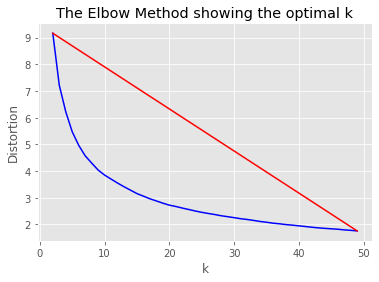

In [28]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [0]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)

In [0]:
# Download the spacy bio parser

from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [0]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

In [0]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [0]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [59]:
from tqdm import tqdm
proccess_text = [] 
for text in tqdm(list(output_df["questions"])):
  proccess_text.append(spacy_tokenizer(text))

100%|██████████| 7990/7990 [01:18<00:00, 101.21it/s]


In [0]:
output_df['processed_text'] = proccess_text
output_df['y'] = y_pred

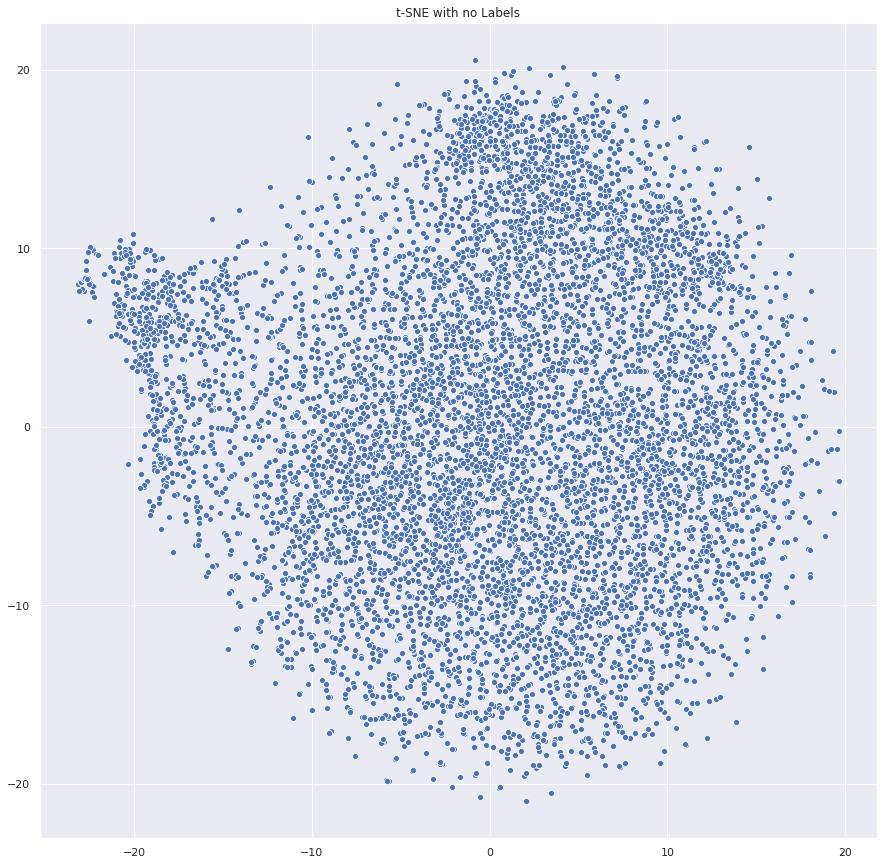

In [32]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_reduced[:,0], X_reduced[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()



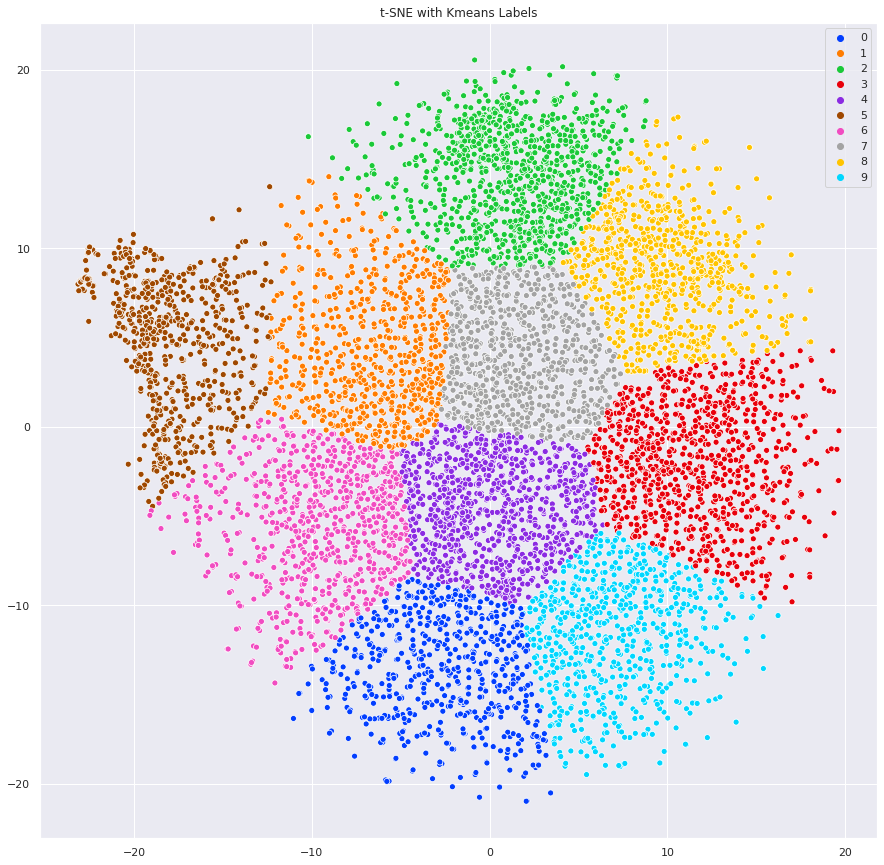

In [40]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
#palette = sns.hls_palette(5, l=.4, s=.9)

# plot
sns.scatterplot(X_reduced[:,0], X_reduced[:,1], hue=y_pred, legend='full', palette=sns.color_palette('bright'))
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

## Topic Modeling

In [0]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [42]:
vectorizers = []
    
for ii in range(0, 20):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))
vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}',
                tokenizer=None, vocabulary=None)

In [61]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(output_df.loc[output_df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

Not enough instances in cluster: 10
Not enough instances in cluster: 11
Not enough instances in cluster: 12
Not enough instances in cluster: 13
Not enough instances in cluster: 14
Not enough instances in cluster: 15
Not enough instances in cluster: 16
Not enough instances in cluster: 17
Not enough instances in cluster: 18
Not enough instances in cluster: 19


In [62]:
len(vectorized_data)

20

In [64]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [0]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

In [0]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [0]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

In [71]:
all_keywords[0][:10]

['governor',
 'reopen',
 'people',
 'think',
 'doe',
 'day',
 'long',
 'china',
 'city',
 'phase']

In [72]:
all_keywords[1][:10]

['question',
 'test',
 'want',
 'president',
 'ask',
 'governor',
 'business',
 'mean',
 'crosstalk',
 'think']